<a href="https://colab.research.google.com/github/tetianasokolova/computer-vision-project/blob/main/CNN_plato_reduced_lr_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Optimization with Reduced Learning Rate on Plato

Optimization of a convolutional neural network on the Plato dataset by applying a reduced learning rate strategy to enhance training stability and model performance.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.utils import make_grid
from collections import defaultdict

## Load the dataset Animals-10
Connect to Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip in Colab's temporary storage
zip_path = "/content/drive/MyDrive/CVDL/Data/Animals-10.zip"
data_path = "/content/raw-img"  # Extract in Colab's temporary storage

if not os.path.exists(data_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")  # Extract directly to /content/

In [ ]:
# Load the data
data = datasets.ImageFolder(root=data_path)

There are 26,179 images in Animal-10 dataset.

In [ ]:
len(data)

26179

Check classes of the data. We see that there are 10 classes of animals.

In [ ]:
# Check class-to-index mapping
data.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Translate classes names from Italian to English using dictionary from Python file in the data archiv.

In [ ]:
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca": "cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

In [ ]:
data.classes = [translate.get(name, name) for name in data.classes]
data.class_to_idx = {name: idx for idx, name in enumerate(data.classes)}

In [ ]:
data.classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

## Split data into train, validation and test
60% - train data, 20% - validation data and 20% - test data. Do stratified split, to ensure the same proportion of images for each class.

In [ ]:
# Extract labels for stratification
labels = np.array(data.targets)

# Split into 80% (train+val) and 20% (test)
train_val_idx, test_idx = train_test_split(
    np.arange(len(data)), test_size=0.2, random_state=42, shuffle=True, stratify=labels
)

# Split 80% (train+val) into 60% train and 20% validation
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.25, random_state=42, shuffle=True, stratify=labels[train_val_idx]
)
# test_size=0.25 ensures val is 20% of total data (20% / 80% = 0.25)

# Create Subsets
train_ds = Subset(data, train_idx)
val_ds = Subset(data, val_idx)
test_ds = Subset(data, test_idx)

In [ ]:
# Print dataset sizes
print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")

Train size: 15707
Validation size: 5236
Test size: 5236


# 1st model

## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5177272, 0.500307 , 0.4125527], std=[0.27112892, 0.26629838, 0.2833791 ])  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

Create a class TransformedSubset to apply separate transformation to each subset after split.

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform)
val_ds = TransformedSubset(val_ds, transform=val_transform)
test_ds = TransformedSubset(test_ds, transform=test_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(15707, 5236, 5236)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## CNN architecture
**5 convolutional blocks**
- 3x3 fiter + padding = 1 to preserve the dimension of the images
- batch normalization
- max pooling with kernel=2 and stride=2
- activaton function ReLU

**3 fully-connected layers**
- dropout 0.3-0.4
- activaton function ReLU

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # Convolutional blocks using nn.Sequential
        # Input: 3x224x224
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x112x112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x56x56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x28x28
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x14x14
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 512x7x7
        )

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 512)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        self.fc_relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc_relu2 = nn.ReLU()

        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        # Convolutional layers
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc_relu1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc_relu2(x)

        x = self.fc3(x)  # Final output
        return x

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
model

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define ReduceLROnPlateau scheduler (reduces LR when val loss stops improving)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

epochs = 50

## Train the model

In [ ]:
# Function to evaluate model
def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Convert tensors to numpy
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, accuracy, f1

In [ ]:
# Train the model
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).detach()  # Prevent unnecessary computation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute training metrics
    train_loss = running_loss / len(train_dl)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dl, loss_function)

    # Step the scheduler (ReduceLROnPlateau requires val_loss)
    scheduler.step(val_loss)

    # Print current learning rate
    print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

Current Learning Rate: 0.0001
Epoch 1/50: Train Loss: 1.7922, Train Acc: 0.3747, Train F1: 0.3412 | Val Loss: 1.4388, Val Acc: 0.5197, Val F1: 0.4953
Current Learning Rate: 0.0001
Epoch 2/50: Train Loss: 1.4199, Train Acc: 0.5137, Train F1: 0.4969 | Val Loss: 1.2139, Val Acc: 0.5901, Val F1: 0.5702
Current Learning Rate: 0.0001
Epoch 3/50: Train Loss: 1.2668, Train Acc: 0.5686, Train F1: 0.5545 | Val Loss: 1.1185, Val Acc: 0.6146, Val F1: 0.6042
Current Learning Rate: 0.0001
Epoch 4/50: Train Loss: 1.1594, Train Acc: 0.6016, Train F1: 0.5910 | Val Loss: 1.0278, Val Acc: 0.6465, Val F1: 0.6286
Current Learning Rate: 0.0001
Epoch 5/50: Train Loss: 1.0817, Train Acc: 0.6335, Train F1: 0.6255 | Val Loss: 1.1210, Val Acc: 0.6308, Val F1: 0.6141
Current Learning Rate: 0.0001
Epoch 6/50: Train Loss: 1.0220, Train Acc: 0.6502, Train F1: 0.6431 | Val Loss: 0.9856, Val Acc: 0.6629, Val F1: 0.6579
Current Learning Rate: 0.0001
Epoch 7/50: Train Loss: 0.9784, Train Acc: 0.6684, Train F1: 0.6632 | 

In [ ]:
# Save best model to file
torch.save(best_model_state, "best_cnn_model.pth")
print("Best model saved with val loss:", best_val_loss)

Best model saved with val loss: 0.496361602870066


## Visualise train results

We see that the model shows steady improvement over 50 epochs.
- **Training loss** drops from 1.7922 to 0.2116, and **validation loss** from 1.4388 to 0.5088, indicating better learning of the model.
- **Training accuracy** rises from 37.47% to 92.98%, and **validation accuracy** from 51.97% to 84.61%, showing good generalization of the model.
- **Train F1 score** improves from 34.12% to 92.97%, and **validation F1 score** from 49.53% to 84.54%, which suggests balanced precision and recall.

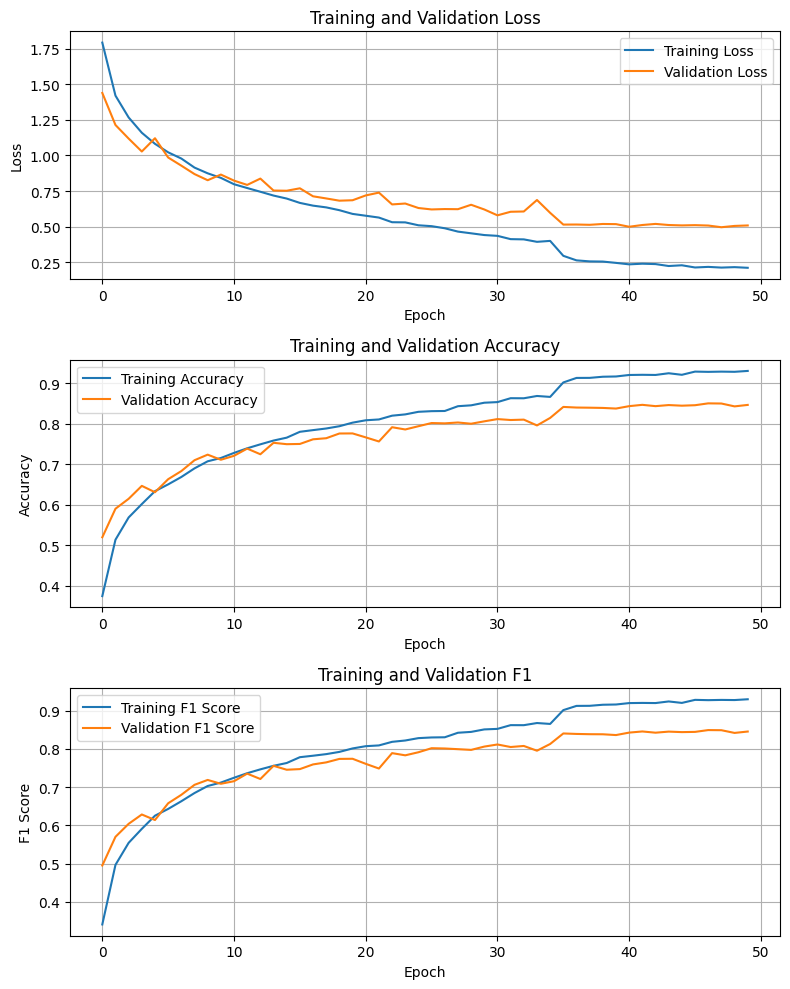

In [ ]:
# Create a figure with a 3 by 1 layout
plt.figure(figsize=(8, 10))

# Plot Loss
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot F1-score
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## Evaluate the model on test data

In [ ]:
from sklearn.metrics import classification_report

predicted_labels = []
true_labels = []

model.eval()   # Set model to evaluation mode
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append predictions and true labels
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate metrics
report = classification_report(true_labels, predicted_labels, target_names=data.classes, digits=4)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         dog     0.7900    0.8469    0.8175       973
       horse     0.8260    0.8590    0.8422       525
    elephant     0.7666    0.8408    0.8020       289
   butterfly     0.9412    0.7962    0.8626       422
     chicken     0.8839    0.8968    0.8903       620
         cat     0.7178    0.7844    0.7496       334
         cow     0.8295    0.6783    0.7463       373
       sheep     0.7855    0.7143    0.7482       364
      spider     0.9090    0.9222    0.9156       964
    squirrel     0.8411    0.8253    0.8331       372

    accuracy                         0.8367      5236
   macro avg     0.8291    0.8164    0.8207      5236
weighted avg     0.8391    0.8367    0.8363      5236



- Overall accuracy of 83.67% on test data indicats good performance.
- **Best performing classes** are **spider** (F1: 0.9156), **chicken** (F1 score: 0.8903) and **butterfly** (F1: 0.8626).
- **Worst performing classes** are **cow** (F1: 0.7463), **sheep** (F1: 0.7482) and **cat** (F1: 0.7496).
- Lower recall in some classes (**cow** and **sheep**) suggests that the model may favor more frequent classes.

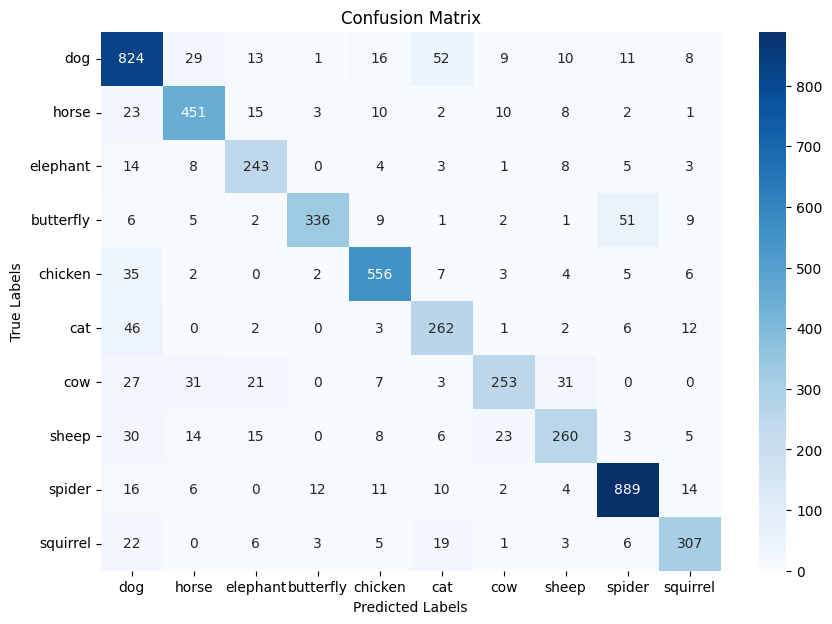

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=data.classes, yticklabels=data.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 2nd model
Try a second model with stronger augmentation, L2 regularization and reduce number of convolutional layers from 5 to 4.

## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

For second model use stronger augmentation for training and validation data.

In [ ]:
train_transform_augment = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize slightly larger first
    transforms.RandomCrop(224),  # Crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally
    transforms.RandomRotation(20),  # Rotation (max 20°)
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Light color changes
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Slight blur (simulates real-world noise)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5177272, 0.500307 , 0.4125527], std=[0.27112892, 0.26629838, 0.2833791])  # Normalize
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5177272, 0.500307 , 0.4125527], std=[0.27112892, 0.26629838, 0.2833791 ])  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform_augment)
val_ds = TransformedSubset(val_ds, transform=train_transform_augment)
test_ds = TransformedSubset(test_ds, transform=test_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(15707, 5236, 5236)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

## CNN architecture
**4 convolutional blocks**
- 3x3 fiter + padding = 1 to preserve the dimension of the images
- batch normalization
- max pooling with kernel=2 and stride=2
- activaton function ReLU

**3 fully-connected layers**
- dropout 0.3-0.4
- activaton function ReLU

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Convolutional blocks using nn.Sequential
        # Input: 3x224x224
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x112x112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x56x56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x28x28
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x14x14
        )

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        self.fc_relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc_relu2 = nn.ReLU()

        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        # Convolutional layers
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc_relu1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc_relu2(x)

        x = self.fc3(x)  # Final output
        return x

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

In [ ]:
model

SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Define ReduceLROnPlateau scheduler (reduces LR when val loss stops improving)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

epochs = 30

## Train the model

In [ ]:
# Function to evaluate model
def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  # Convert tensors to numpy
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, accuracy, f1

In [ ]:
# Train the model
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

best_val_loss = float('inf')
best_model_state = None

prev_lr = optimizer.param_groups[0]['lr']  # Store initial learning rate

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).detach()  # Prevent unnecessary computation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute training metrics
    train_loss = running_loss / len(train_dl)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dl, loss_function)

    # Step the scheduler (ReduceLROnPlateau requires val_loss)
    scheduler.step(val_loss)

    # Get updated learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Print learning rate only if it changed
    if current_lr != prev_lr:
        print(f"Learning Rate Changed: {prev_lr:.6f} → {current_lr:.6f}")
        prev_lr = current_lr  # Update stored learning rate

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

Epoch 1/30: Train Loss: 1.6939, Train Acc: 0.4080, Train F1: 0.3841 | Val Loss: 1.4528, Val Acc: 0.5115, Val F1: 0.4844
Epoch 2/30: Train Loss: 1.5321, Train Acc: 0.4656, Train F1: 0.4467 | Val Loss: 1.4330, Val Acc: 0.5094, Val F1: 0.4887
Epoch 3/30: Train Loss: 1.4437, Train Acc: 0.4968, Train F1: 0.4811 | Val Loss: 1.2813, Val Acc: 0.5672, Val F1: 0.5391
Epoch 4/30: Train Loss: 1.3731, Train Acc: 0.5274, Train F1: 0.5119 | Val Loss: 1.2324, Val Acc: 0.5798, Val F1: 0.5727
Epoch 5/30: Train Loss: 1.3008, Train Acc: 0.5515, Train F1: 0.5384 | Val Loss: 1.2111, Val Acc: 0.5942, Val F1: 0.5876
Epoch 6/30: Train Loss: 1.2544, Train Acc: 0.5717, Train F1: 0.5606 | Val Loss: 1.1670, Val Acc: 0.6117, Val F1: 0.5937
Epoch 7/30: Train Loss: 1.2034, Train Acc: 0.5845, Train F1: 0.5750 | Val Loss: 1.1006, Val Acc: 0.6194, Val F1: 0.6120
Epoch 8/30: Train Loss: 1.1741, Train Acc: 0.5997, Train F1: 0.5907 | Val Loss: 1.0887, Val Acc: 0.6232, Val F1: 0.5999
Epoch 9/30: Train Loss: 1.1352, Train Ac

## Visualise train results

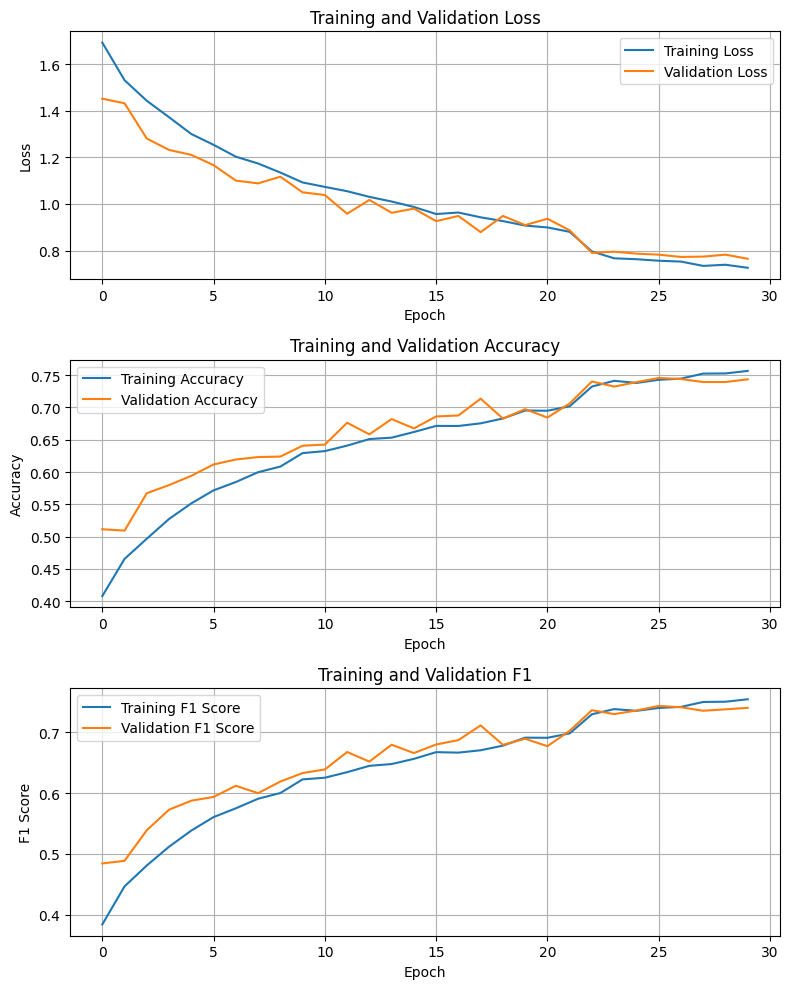

In [ ]:
# Create a figure with a 3 by 1 layout
plt.figure(figsize=(8, 10))

# Plot Loss
plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot F1-score
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## Evaluate the model on test data

In [ ]:
from sklearn.metrics import classification_report

predicted_labels = []
true_labels = []

model.eval()   # Set model to evaluation mode
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append predictions and true labels
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate metrics
report = classification_report(true_labels, predicted_labels, target_names=data.classes, digits=4)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         dog     0.7457    0.7143    0.7297       973
       horse     0.7268    0.7600    0.7430       525
    elephant     0.6522    0.7785    0.7098       289
   butterfly     0.8178    0.8720    0.8440       422
     chicken     0.7836    0.8645    0.8221       620
         cat     0.7783    0.5150    0.6198       334
         cow     0.6348    0.6059    0.6200       373
       sheep     0.6676    0.6511    0.6592       364
      spider     0.8923    0.8942    0.8933       964
    squirrel     0.7143    0.7258    0.7200       372

    accuracy                         0.7620      5236
   macro avg     0.7413    0.7381    0.7361      5236
weighted avg     0.7625    0.7620    0.7598      5236



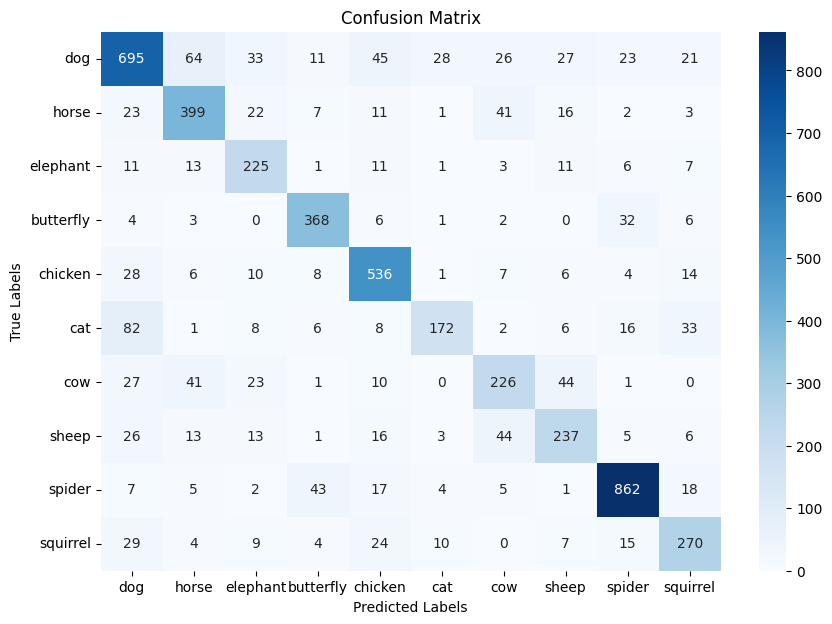

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=data.classes, yticklabels=data.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()